# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [33]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import os


import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#from IPython.display import HTML
#import json
#import altair as alt

# Check Shape and Size of Data
Do work here

In [35]:
train = pd.read_csv('N:\\Users\\Howell\\Kaggle\\Scaler\\champs-scalar-coupling\\train.csv')
test = pd.read_csv('N:\\Users\\Howell\\Kaggle\\Scaler\\champs-scalar-coupling\\test.csv')
sub = pd.read_csv('N:\\Users\\Howell\\Kaggle\\Scaler\\champs-scalar-coupling\\sample_submission.csv')
structure = pd.read_csv('N:\\Users\\Howell\\Kaggle\\Scaler\\champs-scalar-coupling\\structures.csv')

In [36]:
print('train:', train.shape)
print('test:', test.shape)
print('structure:', structure.shape)

train: (4658147, 6)
test: (2505542, 5)
structure: (2358657, 6)


In [37]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [38]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [39]:
structure.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


# Check for null values and duplicate rows
Do work here

In [40]:
train.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64

In [41]:
structure.isna().sum()

molecule_name    0
atom_index       0
atom             0
x                0
y                0
z                0
dtype: int64

In [42]:
train[train.duplicated(subset = None, keep = 'first') == True]

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant


In [43]:
structure[structure.duplicated(subset = None, keep = 'first') == True]

,molecule_name,atom_index,atom,x,y,z


In [44]:
# combine with structures
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df
for atom_idx in [0,1]:
    train = map_atom_info(train,structure, atom_idx)
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

In [45]:
for atom_idx in [0,1]:
    test = map_atom_info(test,structure, atom_idx)
    test = test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

In [46]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0


In [47]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958


In [48]:
test['type'].unique()

array(['2JHC', '1JHC', '3JHH', '3JHC', '2JHH', '1JHN', '3JHN', '2JHN'],
      dtype=object)

In [49]:
train['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

# Analysis - Check for distribution of target variable
Do work here

(array([2.200000e+01, 3.680000e+02, 2.448000e+04, 3.060790e+05,
        6.652030e+05, 2.343922e+06, 5.323860e+05, 2.293200e+04,
        3.793000e+03, 1.242900e+04, 1.025500e+04, 6.048000e+03,
        7.698000e+03, 1.044300e+04, 2.457000e+03, 8.599000e+03,
        1.842870e+05, 2.403080e+05, 8.699300e+04, 4.280500e+04,
        4.593600e+04, 3.815400e+04, 2.431900e+04, 1.794100e+04,
        8.623000e+03, 2.051000e+03, 3.070000e+02, 4.500000e+01,
        3.000000e+00, 1.000000e+00, 0.000000e+00, 1.280000e+02,
        6.893000e+03, 2.239000e+03]),
 array([-36.2186    , -29.12746471, -22.03632941, -14.94519412,
         -7.85405882,  -0.76292353,   6.32821176,  13.41934706,
         20.51048235,  27.60161765,  34.69275294,  41.78388824,
         48.87502353,  55.96615882,  63.05729412,  70.14842941,
         77.23956471,  84.3307    ,  91.42183529,  98.51297059,
        105.60410588, 112.69524118, 119.78637647, 126.87751176,
        133.96864706, 141.05978235, 148.15091765, 155.24205294,
  

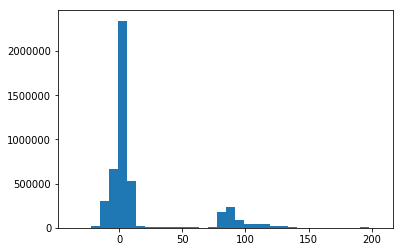

In [50]:
plt.hist(train['scalar_coupling_constant'], bins = 34)

# Feature Engineering from 'https://www.kaggle.com/kmat2019/effective-feature'
Do work here

## Calculate the distance

In [51]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df
train=make_features(train)

In [52]:
test = make_features(test)

In [53]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,C,-0.0126981359,1.085804158,0.0080009958,-0.0148485519,1.0918354756,0.0060248754,1.091953059611900
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,H,1.0117308430,1.463751162,0.0002765748,1.0095804270,1.4697824796,-0.0016995456,1.783119756038801
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5408150690,1.447526614,-0.8766437152,-0.5429654850,1.4535579316,-0.8786198356,1.783147496403011
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,H,-0.5238136345,1.437932644,0.9063972942,-0.5259640505,1.4439639616,0.9044211738,1.783156685329616
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,C,-0.0126981359,1.085804158,0.0080009958,-1.0244289789,-0.3779470040,0.0077244210,1.091951618581363


In [54]:
df_temp=train.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
df_temp_=df_temp.copy()
df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
df_temp=pd.concat((df_temp,df_temp_),axis=0)

df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})

for atom_idx in [0,1]:
    train = map_atom_info(train,df_temp, atom_idx)
    train = train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})

In [55]:
df_temp=test.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
df_temp_=df_temp.copy()
df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
df_temp=pd.concat((df_temp,df_temp_),axis=0)

df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})

for atom_idx in [0,1]:
    test = map_atom_info(test,df_temp, atom_idx)
    test = test.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})

In [56]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,2.2611780778,0.0,0.0,2.2611780778,1,1.0620990942,-0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,1.0620990942,0.0,0.0,1.0620990942,1,1.0620990942,-0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0,3.3232771720,0.0,0.0,3.3232771720,1,1.0620990942,-0.5995394918,0.0,1.0,0,1.0620990942,0.5995394918,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,-1.0620990942,0.0,0.0,1.0620990942,0,1.0620990942,0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,-2.2611780778,0.0,0.0,2.2611780778,0,1.0620990942,0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0


In [57]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df
    
train=add_cos_features(train)

In [58]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,2.2611780778,0.0,0.0,2.2611780778,1,1.0620990942,-0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,1.0620990942,0.0,0.0,1.0620990942,1,1.0620990942,-0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661638586,0.0,1.0,H,1.6616385860,0.0,1.0,3.3232771720,0.0,0.0,3.3232771720,1,1.0620990942,-0.5995394918,0.0,1.0,0,1.0620990942,0.5995394918,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661638586,0.0,1.0,C,0.5995394918,0.0,1.0,-1.0620990942,0.0,0.0,1.0620990942,0,1.0620990942,0.5995394918,0.0,1.0,3,1.0620990942,1.6616385860,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661638586,0.0,1.0,C,-0.5995394918,0.0,1.0,-2.2611780778,0.0,0.0,2.2611780778,0,1.0620990942,0.5995394918,0.0,1.0,2,1.0620990942,-1.6616385860,0.0,1.0


In [59]:
test = add_cos_features(test)

In [60]:
test.isna().sum()

id                      0
molecule_name           0
atom_index_0            0
atom_index_1            0
type                    0
atom_0                  0
x_0                     0
y_0                     0
z_0                     0
atom_1                  0
x_1                     0
y_1                     0
z_1                     0
dx                      0
dy                      0
dz                      0
distance                0
atom_index_closest_0    0
distance_closest_0      0
x_closest_0             0
y_closest_0             0
z_closest_0             0
atom_index_closest_1    0
distance_closest_1      0
x_closest_1             0
y_closest_1             0
z_closest_1             0
distance_0              0
distance_1              0
cos_0_1                 0
cos_0                   0
cos_1                   0
dtype: int64

In [61]:
train.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dx                          0
dy                          0
dz                          0
distance                    0
atom_index_closest_0        0
distance_closest_0          0
x_closest_0                 0
y_closest_0                 0
z_closest_0                 0
atom_index_closest_1        0
distance_closest_1          0
x_closest_1                 0
y_closest_1                 0
z_closest_1                 0
distance_0                  0
distance_1                  0
cos_0_1                     0
cos_0                       0
cos_1                       0
dtype: int

# Modeling
Do work here

In [143]:
from fastai.tabular import *

In [144]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'dx', 'dy', 'dz', 'distance',
       'atom_index_closest_0', 'distance_closest_0', 'x_closest_0',
       'y_closest_0', 'z_closest_0', 'atom_index_closest_1',
       'distance_closest_1', 'x_closest_1', 'y_closest_1', 'z_closest_1',
       'distance_0', 'distance_1', 'cos_0_1', 'cos_0', 'cos_1'],
      dtype='object')

In [145]:
dep_var = 'scalar_coupling_constant'

cat_names = ['type', 'atom_index_closest_0','atom_index_closest_1']

cont_names = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'dx', 'dy', 'dz', 'distance', 'x_closest_0', 'y_closest_0'
              , 'z_closest_0', 'distance_closest_1', 'x_closest_1', 'y_closest_1', 'z_closest_1','distance_0'
              , 'distance_1', 'cos_0_1', 'cos_0', 'cos_1']

procs = [Categorify, Normalize]

In [146]:
te = test.drop(['id', 'molecule_name'], axis=1)
test_data = TabularList.from_df(te, cat_names=cat_names, cont_names = cont_names, procs = procs)

In [147]:
idx = np.random.randint(0, len(tr), size=np.int(.2*len(tr)))

In [148]:
tr = train.drop(['id', 'molecule_name'], axis=1)
bs = 4096
data = (TabularList.from_df(tr, cat_names=cat_names, cont_names = cont_names, procs = procs)
         .split_by_idx(idx)
        .label_from_df(cols=dep_var)
        .add_test(test_data)
        .databunch(bs=bs))

In [149]:
data.show_batch(rows = 10)

type,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
3JHC,1,17,-1.0757,-0.1140,0.1167,0.1690,0.6181,1.1825,1.5277,0.8965,0.9448,0.5565,-0.6709,-0.3796,-0.1654,-0.5076,0.7209,0.7738,1.0691,-0.0808,-0.5076,1.0424,2.2648,-1.5739,2.12971
1JHC,1,13,0.0649,0.0120,0.7691,-0.1224,0.2522,0.1116,-0.2104,0.2825,-0.7709,-1.7066,-0.1297,0.1560,0.1283,-0.4635,0.0746,0.0928,0.7903,-0.0362,-0.4635,-1.5073,-1.2154,1.4158,89.9565
3JHH,0,1,-0.3117,1.0211,0.5571,0.2543,0.0353,-0.7942,0.6593,-1.4140,-1.3556,0.9612,-0.0895,0.9909,-0.0667,-0.4856,-0.0549,0.2091,-0.0436,-0.1275,-0.4856,-1.5046,-0.6324,1.2312,10.5499
3JHC,4,12,-1.2811,-0.5698,-1.8106,-1.1255,0.0098,-0.0325,0.4198,0.8241,2.0246,0.9594,-1.1711,-0.1823,-2.0989,-0.4876,-1.2023,0.2679,0.5651,-0.1782,-0.4876,0.8777,0.5835,-1.4460,0.006296
3JHC,2,15,-1.2422,-0.0906,-0.0384,0.8378,-0.1654,-0.2493,2.4421,-0.0672,-0.1836,1.4588,-0.8856,-0.2001,-0.5443,-0.5060,0.7467,-0.5298,-0.7145,-0.0953,-0.5060,1.0012,-0.5837,-0.3380,7.53647
2JHN,6,10,-1.6871,-0.1963,1.0702,-0.6258,-0.5199,1.4312,1.4563,-0.3375,0.0896,-0.2868,-1.3699,-0.0271,1.1666,1.8557,0.6657,-0.4971,0.8537,-0.1305,1.8557,1.6955,0.0602,-1.5553,3.2882
3JHH,4,5,-2.0080,-1.0519,0.1409,-1.7797,-2.3892,0.8072,0.6415,-1.3372,0.5755,0.1652,-1.8545,-1.2196,0.7274,-0.4865,-1.5520,-1.6817,1.1205,-0.0681,-0.4865,0.7455,1.4019,0.6389,4.84435
2JHH,4,4,0.7319,-0.8546,0.8690,0.0666,-0.8115,0.0429,-0.8479,0.2550,-0.9469,-0.8137,0.7374,-0.6748,0.3621,-0.4816,0.6272,-0.5396,0.2920,-0.0731,-0.4816,-0.3296,-0.2154,1.1070,-12.698
2JHC,3,13,1.3276,-0.6242,-1.2826,0.4439,-0.0440,-1.0362,-1.1972,0.8378,0.5112,-0.3130,1.2373,-0.5232,-0.9729,-0.5023,0.1317,0.0737,-1.4922,-0.1872,-0.5023,-0.5388,-0.4636,-0.3341,-0.444319
3JHH,1,1,0.3931,0.9579,0.0498,0.2473,0.0835,-0.8748,-0.2322,-1.2666,-0.8534,0.0277,-0.0584,0.1449,-0.0963,-0.4685,-0.0439,0.2052,-0.0742,6.6308,-0.4685,-0.1000,-0.6527,0.7691,0.732288


In [150]:
data.show_batch(rows=5, ds_type=DatasetType.Valid)

type,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
1JHC,5,9,-1.0354,1.3290,-0.5176,-0.5609,1.5234,-0.9576,0.7071,-0.0861,-0.2851,-1.7239,-0.5824,1.3923,-0.9874,-0.4929,-0.5380,1.1168,-1.4446,-0.1362,-0.4929,0.7126,-1.2154,-0.6753,89.9489
3JHH,3,4,-1.2013,-1.1413,-0.0410,-0.0801,-0.8892,-1.6991,1.4225,0.5714,-1.5014,0.7679,-0.7891,-1.0639,-0.0836,-0.4919,-0.0388,-1.0780,-0.7870,-0.1571,-0.4919,-0.1901,0.1855,0.9237,-0.226609
3JHC,5,17,-0.9287,-1.6703,0.2151,0.3154,-0.3169,0.7643,1.4977,2.0053,0.4523,1.6325,-0.6402,-1.6810,0.8185,-0.5060,0.6710,-0.2166,1.2078,-0.1806,-0.5060,1.6987,-0.4262,-1.0898,2.65231
3JHC,4,18,1.2530,-1.3718,-0.3923,1.4142,-0.0759,0.5601,-0.0800,1.8658,0.9553,0.7760,1.0929,-1.1112,-0.4556,-0.5093,1.6630,0.1837,0.8848,-0.1364,-0.5093,0.1963,-0.0628,-1.1622,0.522797
2JHC,8,16,-0.4745,-0.3712,-1.2366,-0.0290,0.1986,-0.0230,0.5646,0.7651,1.3820,-0.0820,0.0117,-0.3609,-1.0678,2.0050,-0.6651,-0.5600,0.7983,-0.1864,2.0050,-0.0562,-0.3458,-0.1710,5.44805


In [151]:
data.show_batch(rows=5, ds_type=DatasetType.Test)

type,atom_index_closest_0,atom_index_closest_1,x_0,y_0,z_0,x_1,y_1,z_1,dx,dy,dz,distance,x_closest_0,y_closest_0,z_closest_0,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,target
2JHC,1,3,-1.0046,0.1039,0.6091,0.3391,0.2240,0.7341,1.6180,0.1178,-0.0222,-0.1355,-0.4897,0.1286,0.7780,-0.5587,0.9223,0.1904,0.6241,-0.3641,-0.5587,1.8007,-1.2154,-1.7002,0
1JHC,1,2,-1.0046,0.1039,0.6091,-0.4712,0.2240,0.7341,0.7632,0.1178,-0.0222,-1.7633,-0.4897,0.1286,0.7780,-0.5587,-1.0324,0.1904,0.6241,-0.3641,-0.5587,-1.5073,-1.2154,1.4158,0
3JHH,1,0,-1.0046,0.1039,0.6091,1.0569,0.2240,0.7341,2.3751,0.1178,-0.0222,1.3064,-0.4897,0.1286,0.7780,-0.5587,0.2976,0.1904,0.6241,-0.3641,-0.5587,-1.5073,-1.2154,1.4158,0
1JHC,0,3,0.8839,0.1039,0.6091,0.3391,0.2240,0.7341,-0.7511,0.1178,-0.0222,-1.7633,0.3466,0.1286,0.7780,-0.5587,0.9223,0.1904,0.6241,-0.3641,-0.5587,-1.5073,-1.2154,1.4158,0
2JHC,0,2,0.8839,0.1039,0.6091,-0.4712,0.2240,0.7341,-1.6058,0.1178,-0.0222,-0.1355,0.3466,0.1286,0.7780,-0.5587,-1.0324,0.1904,0.6241,-0.3641,-0.5587,1.8007,-1.2154,-1.7002,0


In [152]:
def mean_absolute_error_fastai(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return F.l1_loss(pred, targ)

In [153]:
learn = tabular_learner(data, 
                        layers=[1000,500,100], 
                        emb_drop=0.04,
                        ps=(0.001, 0.01, 0.1),
                        metrics=[mean_absolute_error_fastai, rmse], 
                        wd=1e-2).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


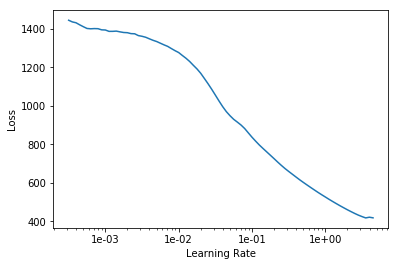

In [154]:
lr_find(learn, start_lr=1e-4, end_lr=10, num_it=100) #, start_lr=1e-2, end_lr=10, num_it=200
learn.recorder.plot()

In [155]:
learn.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,mean_absolute_error_fastai,root_mean_squared_error,time
0,14.268958,10.805768,1.931970,3.284497,03:17


In [75]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(16, 8)
    (2): Embedding(30, 11)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=46, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Check metrics

In [137]:
val_preds = learn.get_preds(DatasetType.Valid)
y_true = tr.iloc[idx].scalar_coupling_constant
y_preds = val_preds[0][:,0].numpy()
types = tr.iloc[idx].type

# Results
Show graphs and stats here

In [130]:
maes = []
for t in types.unique():
    y_t = pd.Series(y_true[types==t])
    y_p = pd.Series(y_preds[types==t])
    mae = np.log(mean_absolute_error(y_t, y_p))
    maes.append(mae)

np.mean(maes), np.log(mean_absolute_error(y_true, y_preds)), mean_absolute_error(y_true, y_preds)

AttributeError: 'Series' object has no attribute 'contiguous'

In [131]:
for t in types.unique():
    print(t)

1JHC
3JHC
2JHN
3JHN
2JHC
2JHH
3JHH
1JHN


# Make submission file

In [156]:
test_preds = learn.get_preds(DatasetType.Test)
preds = test_preds[0].numpy()

In [157]:
benchmark = sub.copy()
benchmark['scalar_coupling_constant'] = preds
benchmark.to_csv('N:\\Users\\Howell\\Kaggle\\Scaler\\submission_1.csv', index=False)

# Conclusions and Next Steps
Summarize findings here

In [158]:
benchmark

,id,scalar_coupling_constant
0,4658147,15.8593750000000
1,4658148,183.0000000000000
2,4658149,6.6328125000000
3,4658150,187.7500000000000
4,4658151,16.4375000000000
5,4658152,88.5625000000000
6,4658153,2.4003906250000
7,4658154,-9.9765625000000
8,4658155,-8.6875000000000
9,4658156,88.4375000000000
